In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import median
from tqdm import tqdm

In [2]:
# Getting the Dataset from my Github Repo
!wget --no-check-certificate https://raw.githubusercontent.com/mihirjain-iitgn/dataset_dS_A1/main/dataset.csv
!wget --no-check-certificate https://raw.githubusercontent.com/mihirjain-iitgn/dataset_dS_A1/main/queries.csv

--2021-07-02 19:56:20--  https://raw.githubusercontent.com/mihirjain-iitgn/dataset_dS_A1/main/dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11296921 (11M) [text/plain]
Saving to: ‘dataset.csv’

dataset.csv         100%[===================>]  10.77M  22.5MB/s    in 0.5s    

2021-07-02 19:56:20 (22.5 MB/s) - ‘dataset.csv’ saved [11296921/11296921]

--2021-07-02 19:56:20--  https://raw.githubusercontent.com/mihirjain-iitgn/dataset_dS_A1/main/queries.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9954 (9.7K) [text/

In [3]:
class HashFunction1():
  def __init__(self, n):
    """
    Parameters :
    > n : int. The range of ouput of the hash function will be [0,n)

    The hash is calculated using the following formula :
    > ((a*x)mod(p))mod(n)
      > x : Input
      > p : A big prime number. Taken to be 2**31 in this implementation.
      > a : A number in range [1,p)
      > b : A number in range [1,p)
    """
    self.__n = n
    self.__p = 2147483647
    self.__a = np.random.randint(1,self.__p) 
    self.__b = np.random.randint(1,self.__p)
  
  def __getitem__(self,x):
    """
    Parameters :
    > x : int. Number whose hash is to be calculated.
    """
    return ((self.__a*x+self.__b)%self.__p)%self.__n

In [4]:
class HashFunction2():
  def __init__(self):
    """
    The hash is calculated using the following formula :
    > ((a*x)mod(p))mod(2)
      > x : Input
      > p : A big prime number. Taken to be 2**31 in this implementation.
      > a : A number in range [0,p)
    > The range of the output of the hash function is {0,1}. To get the range as {-1,1}, all 0s are returned as -1.
    """
    self.__p = 2147483647
    self.__a = np.random.randint(1,self.__p) 
    self.__b = np.random.randint(1,self.__p)
  
  def __getitem__(self,x):
    """
    Parameters :
    > x : int. Number whose hash is to be calculated.
    """
    if ((self.__a*x + self.__b)%self.__p)%2 == 1:
      # Result of hash is 1
      return 1
    else:
      # Result of hash is 0
      return -1

In [5]:
class MisraGries():

  def __init__(self, k):
    """
    Parameters :
    > k : int. Number of Counters.

    Other Variables Initialised :
    > __used : int. The current number of elements in the sketch.
    > __elements : Dictionary. Stores the estimates of the frequencies of present elements.
    """
    self.__k = k
    self.__used = 0
    self.__elements = {}
  
  def process(self, x, y):
    """
    Parameters :
    > x : int. Identifier for an element.
    > y : int. Frequency for this element/
    """
    if x in self.__elements:
      # Element already in the sketch.
      self.__elements[x] += y
    elif self.__k>self.__used:
      # Element not there but there is space.
      self.__elements[x] = y
      self.__used += 1
    else:
      # Element not present and no space.
      self.__decrement(x,y)
    
  def query(self,x):
    """
    Parameters :
    > x : int. Element whose frequency is queried.
    """
    if x in self.__elements:
      # Element Present.
      return self.__elements[x]
    else:
      # 0 is used an estimate for other elements.
      return 0

  def __decrement(self,x,y):
    """
    Parameters :
    > x : int. Identifier for an element.
    > y : int. Frequency for this element/
    """
    # Will hold the largest frequency smaller than y.
    mm = -1
    for key in self.__elements:
      if y>self.__elements[key]:
        mm = max(self.__elements[key],mm)
    keys = list(self.__elements.keys()).copy()
    if mm == -1:
      # No frequency is smaller than y
      for key in keys:
        self.__elements[key] -= y
    else:
      # Atleast one element has frequency smaller than y.
      for key in keys:
        self.__elements[key] -= mm
        # All elements with frequency smaller or equal to mm are thrown.
        if 0 >= self.__elements[key]:
          self.__elements.pop(key)
          self.__used -= 1
      # x is added to the sketch.
      self.__elements[x] = y-mm # mm must substracted from y also.
      self.__used += 1

In [6]:
class CountMin():

  def __init__(self, w, d):
    """
    Parameters :
    > w : int. Number of Rows.
    > d : int. Number of columns.

    Other Variables Initialised :
    > __summary : 2D Array used in the Sketch.
    > __hashFunctions : List of hashfunctions, one for each row.
    """
    self.__w = w
    self.__d = d
    self.__summary = np.zeros((w,d))
    self.__hashFunctions = [HashFunction1(d) for _ in range(w)]
  
  def process(self,x,y):
    """
    Parameters :
    > x : int. Identifier for an element.
    > y : int. Frequency for this element/
    """
    w,d = self.__w, self.__d
    hashFunctions = self.__hashFunctions
    for i in range(w):
      # a stores the column index
      a = hashFunctions[i][x]
      self.__summary[i][a] += y
  
  def query(self,x):
    """
    Parameters :
    > x : int. Element whose frequency is queried.
    """
    w,d = self.__w, self.__d
    hashFunctions = self.__hashFunctions
    ans = float('inf')
    for i in range(w):
      a = hashFunctions[i][x]
      b = self.__summary[i][a]
      # Taking min estimates from each row.
      ans = min(ans,b)
    return ans

In [7]:
class Count():
  def __init__(self,w,d):
    """
    Parameters :
    > w : int. Number of Rows.
    > d : int. Number of columns.

    Other Variables Initialised :
    > __summary : 2D Array used in the Sketch.
    > __hashFunctions1 : List of hashfunctions, one for each row. Will map to one of the columns in a row.
    > __hashFunctions2 : List of hashfunctions, one for each row. Will map to -1 or 1.
    """
    self.__w = w
    self.__d = d
    self.__summary = np.zeros((w,d))
    self.__hashFunctions1 = [HashFunction1(d) for _ in range(w)]
    self.__hashFunctions2 = [HashFunction2() for _ in range(w)]
  
  def process(self,x,y):
    """
    Parameters :
    > x : int. Identifier for an element.
    > y : int. Frequency for this element/
    """
    w,d = self.__w, self.__d
    hashFunctions1 = self.__hashFunctions1
    hashFunctions2 = self.__hashFunctions2
    for i in range(w):
      # a stores the column index
      a = hashFunctions1[i][x]
      # b is either -1 or 1
      b = hashFunctions2[i][x]
      self.__summary[i][a] += (b*y)
  
  def query(self,x):
    w,d = self.__w, self.__d
    hashFunctions1 = self.__hashFunctions1
    hashFunctions2 = self.__hashFunctions2
    # Will stores the estimates from each row.
    vals = []
    for i in range(w):
      a = hashFunctions1[i][x]
      b = hashFunctions2[i][x]
      val = b*self.__summary[i][a]
      vals.append(val)
    # Returning the Median
    return median(vals)

In [8]:
# Data Stream
data = np.array(pd.read_csv("/content/dataset.csv", header = None))
print(data.shape)

# Top 1k most frequent elements
queries = np.array(pd.read_csv("/content/queries.csv", header = None))
print(queries.shape)

# Creating Random sample of size 100
queries = queries[np.random.randint(0,1000,100)]
print(queries.shape)

(1467345, 2)
(1000, 2)
(100, 2)


In [9]:
w = 5
cms_errors = []
for k in [100,500,1000,2000]:
  d = k//w
  CMS = CountMin(w,d)
  for i in tqdm(range(len(data))):
    x,y = data[i][0],data[i][1]
    CMS.process(x,y)
  err = 0
  for i in range(len(queries)):
    x,y = queries[i][0],queries[i][1]
    yhat = CMS.query(x)
    err += (abs(yhat-y)/y)
  err = err/len(queries)
  cms_errors.append(err)

100%|██████████| 1467345/1467345 [00:20<00:00, 71851.45it/s]


In [10]:
w = 5
cs_errors = []
for k in [100,500,1000,2000]:
  d = k//w
  CS = Count(w,d)
  for i in tqdm(range(len(data))):
    x,y = data[i][0],data[i][1]
    CS.process(x,y)
  err = 0
  for i in range(len(queries)):
    x,y = queries[i][0],queries[i][1]
    yhat = CS.query(x)
    err += (abs(yhat-y)/y)
  err = err/len(queries)
  cs_errors.append(err)

100%|██████████| 1467345/1467345 [00:36<00:00, 40739.01it/s]


In [11]:
mgs_errors = []
for k in [100,500,1000,2000]:
  MGS = MisraGries(k)
  for i in range(len(data)):
    x,y = data[i][0],data[i][1]
    MGS.process(x,y)
    err = 0
  for i in range(len(queries)):
    x,y = queries[i][0],queries[i][1]
    yhat = MGS.query(x)
    err += (abs(yhat-y)/y)
  err = err/len(queries)
  mgs_errors.append(err)

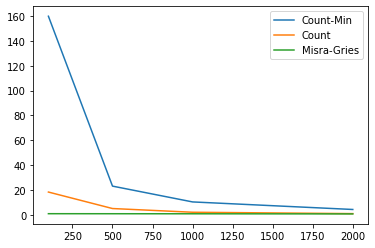

In [12]:
plt.plot([100,500,1000,2000], cms_errors, label = "Count-Min")
plt.plot([100,500,1000,2000], cs_errors, label = "Count")
plt.plot([100,500,1000,2000], mgs_errors, label = "Misra-Gries")
plt.legend(loc='best')
plt.show()